In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd, matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from pathlib import Path
from PIL import Image
import shutil, os, subprocess, tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
root_dir = Path("/content/drive/MyDrive/281_final_project/plane_classification_data")
IMG_EXTS = {".jpg", ".jpeg", ".png"}
categories = ["pituitary", "notumor", "glioma", "meningioma"]

In [47]:
image_paths = sorted(
    str(p)
    for split in ("Training", "Testing")
    for cat   in categories
    for p     in (root_dir / split / cat).rglob("*")
    if p.suffix.lower() in IMG_EXTS
)
print("Total images =", len(image_paths))

Total images = 7033


In [36]:
# image_paths = sorted(
#     str(p)
#     for split in ("Training", "Testing")
#     for p in (root_dir / split / "glioma").rglob("*")
#     if p.suffix.lower() in IMG_EXTS
# )
# print("Total images =", len(image_paths))

Total images = 1621


In [48]:
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.grayscale_to_rgb(img)  #Mobilenet needs 3 channels
    img = preprocess_input(img)
    return img

imgs = tf.stack([load_and_preprocess(p) for p in tqdm(image_paths)])
print("Image batch shape:", imgs.shape)

100%|██████████| 7033/7033 [16:43<00:00,  7.01it/s] 


Image batch shape: (7033, 224, 224, 3)


In [49]:
base_model = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")

/tmp/ipython-input-49-328381523.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")


In [50]:
features = base_model.predict(imgs, verbose=1)
print("Feature shape:", features.shape)

220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step
Feature shape: (7033, 1280)


In [51]:
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(features)

To extract the penultimate layer uncomment the following code blocks and comment out the pca code

In [8]:
# base_model_p = MobileNetV2(include_top=False, weights="imagenet")
# layer_names = [layer.name for layer in base_model_p.layers]
# print(layer_names)

/tmp/ipython-input-8-1275442523.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_p = MobileNetV2(include_top=False, weights="imagenet")


['input_layer_2', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_e

In [14]:
# #Same as above, but without top
# base_model_p = MobileNetV2(include_top=False, weights="imagenet")

# penultimate_layer_output = base_model_p.get_layer('out_relu').output #Conv_1_bn?

# # Define a new model up to that layer
# model2 = Model(inputs=base_model_p.input, outputs=penultimate_layer_output)

# feature_maps = model2.predict(imgs, verbose=1)
# flattened = feature_maps.reshape(feature_maps.shape[0], -1)  # (batch_size, 7*7*320)
# print("Feature maps shape:", flattened.shape)

/tmp/ipython-input-14-3553356912.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_p = MobileNetV2(include_top=False, weights="imagenet")


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step
Feature maps shape: (1767, 62720)


In [52]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features) #Change reduced_features to flattened if using PCA pipeline

In [57]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(reduced_features)

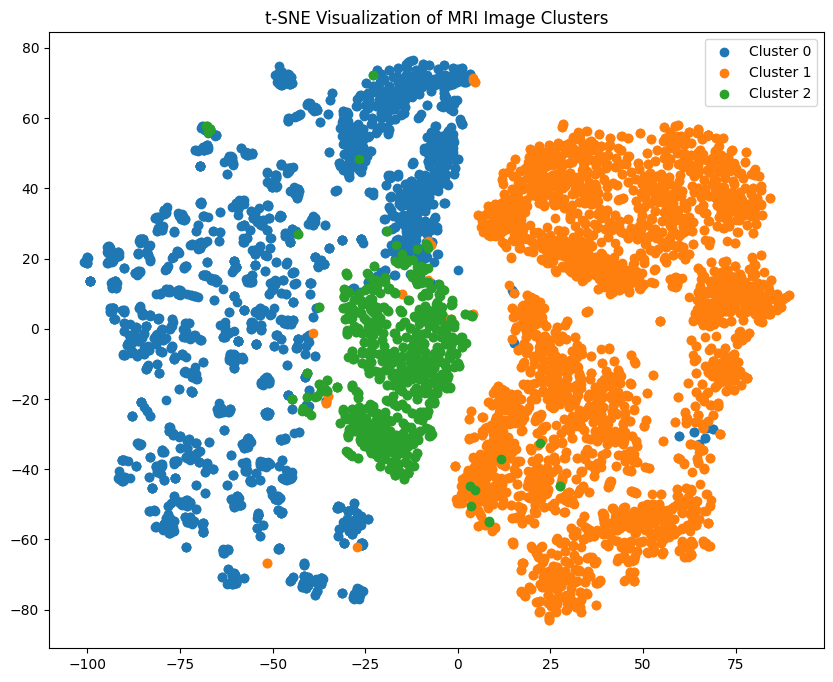

In [58]:
plt.figure(figsize=(10, 8))
for i in range(3):
    idx = cluster_labels == i
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f"Cluster {i}")
plt.legend()
plt.title("t-SNE Visualization of MRI Image Clusters")
plt.show()

In [59]:
def show_cluster(cluster_id, num_samples=10):
    idxs = np.where(cluster_labels == cluster_id)[0][:num_samples]
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        img = Image.open(image_paths[idx])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Cluster {cluster_id}")
        plt.axis('off')
    plt.show()

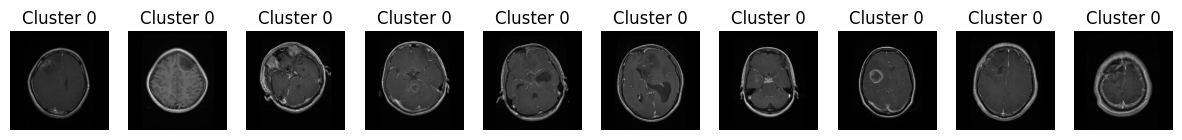

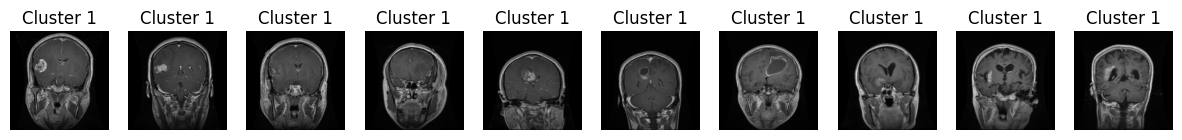

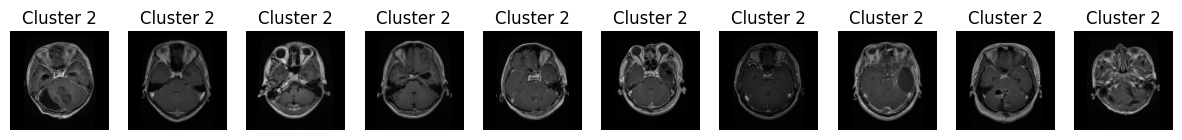

In [60]:
for c in range(3):
    show_cluster(c)

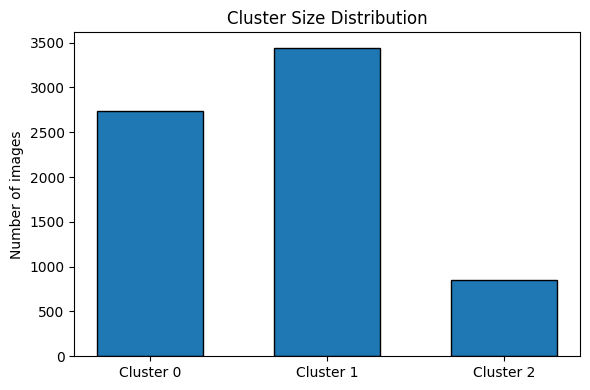

In [61]:
unique, counts = np.unique(cluster_labels, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, width=0.6, edgecolor='k')
plt.xticks(unique, [f"Cluster {i}" for i in unique])
plt.ylabel("Number of images")
plt.title("Cluster Size Distribution")
plt.tight_layout()
plt.show()

In [22]:
# TP_cluster_df = pd.DataFrame({
#     "image_path": image_paths,
#     "cluster": cluster_labels
# })

# #Change mapping
# TP_cluster_name_map = {
#     0: "sagittal",
#     1: "axial",
#     2: "coronal"
# }
# TP_cluster_df["cluster"] = TP_cluster_df["cluster"].map(TP_cluster_name_map)
# TP_cluster_df.rename(columns={"cluster": "anatomical_view"}, inplace=True)

In [ ]:
# TP_cluster_df

,image_path,anatomical_view
0,/content/drive/MyDrive/281_final_project/plane...,axial
1,/content/drive/MyDrive/281_final_project/plane...,coronal
2,/content/drive/MyDrive/281_final_project/plane...,coronal
3,/content/drive/MyDrive/281_final_project/plane...,sagittal
4,/content/drive/MyDrive/281_final_project/plane...,sagittal
...,...,...
1762,/content/drive/MyDrive/281_final_project/plane...,coronal
1763,/content/drive/MyDrive/281_final_project/plane...,coronal
1764,/content/drive/MyDrive/281_final_project/plane...,coronal
1765,/content/drive/MyDrive/281_final_project/plane...,coronal


In [ ]:
TP_cluster_df = TP_cluster_df.dropna(subset=["anatomical_view"]).reset_index(drop=True)

In [ ]:
TP_cluster_df.to_csv("pituitary_views_named.csv", index=False)

In [ ]:
TP_cluster_df = pd.read_csv("/content/drive/MyDrive/281_final_project/pituitary_views_named.csv")

In [ ]:
TP_cluster_df

,image_path,anatomical_view
0,/content/drive/MyDrive/281_final_project/plane...,axial
1,/content/drive/MyDrive/281_final_project/plane...,coronal
2,/content/drive/MyDrive/281_final_project/plane...,coronal
3,/content/drive/MyDrive/281_final_project/plane...,sagittal
4,/content/drive/MyDrive/281_final_project/plane...,sagittal
...,...,...
1762,/content/drive/MyDrive/281_final_project/plane...,coronal
1763,/content/drive/MyDrive/281_final_project/plane...,coronal
1764,/content/drive/MyDrive/281_final_project/plane...,coronal
1765,/content/drive/MyDrive/281_final_project/plane...,coronal


In [ ]:
TP_cluster_name_map = {
    0: "sagittal",
    1: "axial",
    2: "coronal"
}